### 关于数据
建立一个逻辑回归模型来预测一个学生是否被大学录取。假设你是一个大学系的管理员，你想根据两次考试的结果来决定每个申请人的录取机会。你有以前的申请人的历史数据，你可以用它作为逻辑回归的训练集。对于每一个培训例子，由两个考试的申请人的分数和录取决定。为了做到这一点，建立一个分类模型，根据考试成绩估计入学概率。

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os

In [9]:
path = 'data/LogiReg_data.txt'
pdData = pd.read_csv(path,names=['Exam 1', 'Exam 2', 'Admitted'])
pdData.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [10]:
pdData.shape

(100, 3)

Text(0,0.5,'Exam 2 Score')

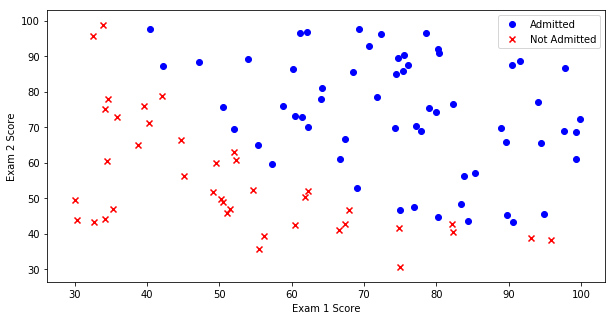

In [11]:
positive = pdData[pdData['Admitted'] == 1]#正例
negative = pdData[pdData['Admitted'] == 0]#反例

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(positive['Exam 1'], positive['Exam 2'], label='Admitted', marker='o', color='b')
ax.scatter(negative['Exam 1'], negative['Exam 2'], color='r', marker='x', label='Not Admitted')
ax.legend()
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')

### sigmoid 函数
将预测值压缩到（0，1）之间，转化为概率
$$
g(z) = \frac{1}{1+e^{-z}} 
$$


In [12]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

### 求内积
$$
\begin{array}{ccc}
\begin{pmatrix}1 & x_1 & x_2\end{pmatrix}
& \times & 
\begin{pmatrix} \theta_{0} \\ \theta_{1} \\ \theta_{2}\end{pmatrix}
\end{array}
=\theta_{0}+\theta_{1}x_{1}+\theta_{2}x_{2}
$$

In [13]:
def model(X, theta):
    return sigmoid(np.dot(X, theta.T))

In [14]:
pdData.insert(0, 'ones', 1)#插入常数列，即θ零的系数列
pdData.head()

,ones,Exam 1,Exam 2,Admitted
0,1,34.623660,78.024693,0
1,1,30.286711,43.894998,0
2,1,35.847409,72.902198,0
3,1,60.182599,86.308552,1
4,1,79.032736,75.344376,1


In [15]:
#将数据集转化为矩阵
origData = pdData.values
cols = origData.shape[1]
print(cols)

4


In [16]:
#拆分特征和结果，初始化θ
X = origData[:, 0:cols-1]
y = origData[:, cols-1:cols]
theta = np.zeros([1, 3])

In [17]:
X[:5]

array([[ 1.        , 34.62365962, 78.02469282],
       [ 1.        , 30.28671077, 43.89499752],
       [ 1.        , 35.84740877, 72.90219803],
       [ 1.        , 60.18259939, 86.3085521 ],
       [ 1.        , 79.03273605, 75.34437644]])

In [18]:
y[:5]

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.]])

In [19]:
theta

array([[0., 0., 0.]])

In [20]:
X.shape, y.shape, theta.shape

((100, 3), (100, 1), (1, 3))

### 损失函数
似然函数  
分类任务：
$$
P(y=1|x;\theta)=h_\theta(x);P(y=0|x;\theta)=1-h_\theta(x)
$$
整合：
$$
P(y|x;\theta) = (h_\theta(x))^y(1-h_\theta(x))^{1-y}
$$
将对数似然函数去负号
$$
D(h_\theta(x), y) = -y\log(h_\theta(x)) - (1-y)\log(1-h_\theta) 
$$
求平均损失
$$
J(\theta) = \frac{1}{n}\sum_{i=1}^{n}D(h_\theta(x_i), y_i)
$$

In [21]:
def cost(X, y, theta):
    left = np.multiply(-y, np.log(model(X, theta)))
    right = np.multiply(1 - y, np.log(1 - model(X, theta)))
    return np.sum(left - right) / (len(X))
#当theta = [0, 0, 0] 时的损失值
cost(X, y, theta)

0.6931471805599453

### 计算梯度
$$
\frac{\partial J}{\partial \theta_j}=-\frac{1}{m}\sum_{i=1}^n (y_i - h_\theta (x_i))x_{ij}
$$


In [23]:
def gradient(X, y, theta):
    grad = np.zeros(theta.shape)
    error = (model(X, theta)-y).ravel()
    for j in range(len(theta.ravel())):
        t = np.multiply(error, X[:, j])
        grad[0, j] = np.sum(t) / len(X)
    return grad

### Gradient descent
比较3种不同梯度下降方法

In [24]:
STOP_ITER = 0#迭代次数
STOP_COST = 1#损失值差值
STOP_GRAD = 2#梯度变化

def stopCriterion(type, value, threshold):
    if type == STOP_ITER:        return value > threshold
    elif type == STOP_COST:        return abs(value[-1] - value[-2]) < threshold
    elif type == STOP_GRAD:        return np.linalg.norm(value) < threshold

In [25]:
#打乱数据，增强模型一般性
def shuffleData(data):
    np.random.shuffle(data)
    cols = data.shape[1]
    X = data[:, :cols-1]
    y = data[:, cols-1:]
    return X, y

In [26]:
def descent(data, theta, stopType, thresh, alpha):
    i = 0
    grad = np.zeros(theta.shape)
    X, y = shuffleData(data)
    costs = [cost(X, y, theta)]
    gradList = []
    while True:
        X, y = shuffleData(data)
        grad = gradient(X, y, theta)
        if i % 100 == 0:
            gradList.append(np.linalg.norm(grad))
        theta = theta - alpha * grad
        costs.append(cost(X, y, theta))
        i += 1
        if stopType == STOP_ITER:        value = i
        elif stopType == STOP_COST:      value = costs
        elif stopType == STOP_GRAD:      value = grad
        if stopCriterion(stopType, value, thresh) or i > 50000:break 
    return theta, costs

In [27]:
def Run(data, theta, stopType, thresh, alpha):
    theta, costs = descent(data, theta, stopType, thresh, alpha)
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(np.arange(len(costs)), costs, 'r')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    return theta

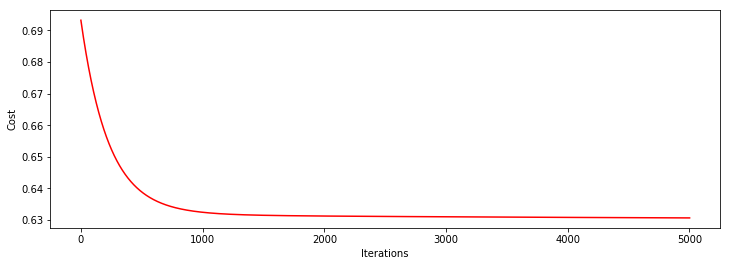

In [28]:
#迭代次数与损失值的关系
theta1 = Run(origData, theta, STOP_ITER, 5000, 0.000001)

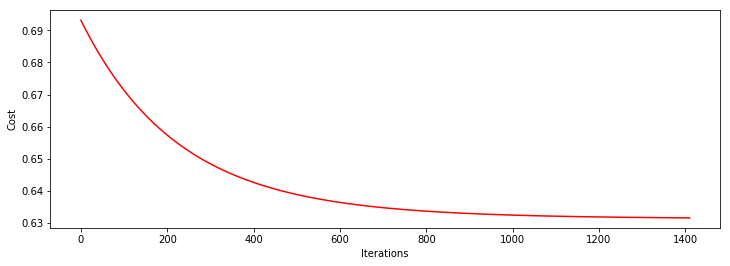

In [29]:
#损失值差值小于1E-6时停止迭代
theta2 = Run(origData, theta, STOP_COST, 0.000001, 0.000001)

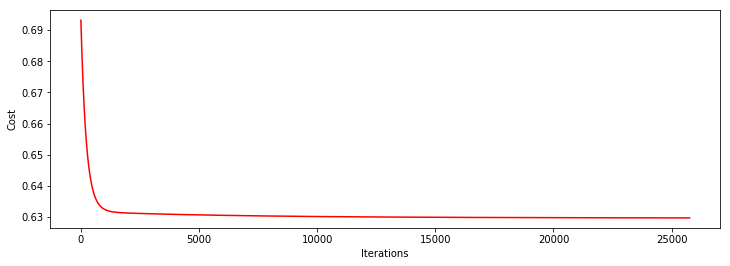

In [30]:
#梯度小于0.1时，停止迭代
theta3 = Run(origData, theta, STOP_GRAD, 0.1, 0.000001)

In [34]:
#复制原始数据，准备对数据做标准化处理
scaleData = origData.copy()
scaleData[:5]

array([[ 1.        , 33.91550011, 98.86943574,  0.        ],
       [ 1.        , 79.94481794, 74.16311935,  1.        ],
       [ 1.        , 45.08327748, 56.31637178,  0.        ],
       [ 1.        , 34.52451385, 60.39634246,  0.        ],
       [ 1.        , 61.10666454, 96.51142588,  1.        ]])

[[ 1.         -1.63882482  1.76571557  0.        ]
 [ 1.          0.73863826  0.42949041  1.        ]
 [ 1.         -1.06199728 -0.5357394   0.        ]
 [ 1.         -1.60736862 -0.31507682  0.        ]
 [ 1.         -0.23437234  1.63818413  1.        ]]


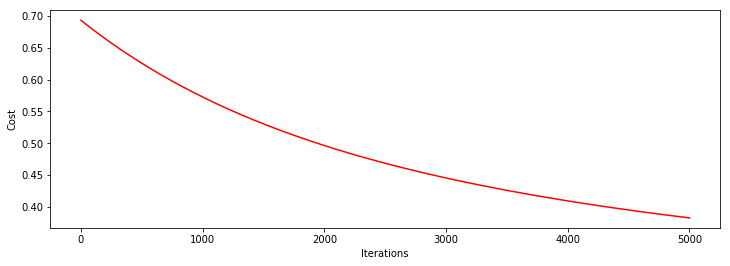

In [35]:
from sklearn import preprocessing as pp
scaleData[:, 1:3] = pp.scale(origData[:, 1:3])
print(scaleData[:5])
theta4 = Run(scaleData, theta, STOP_ITER, 5000, 0.001)

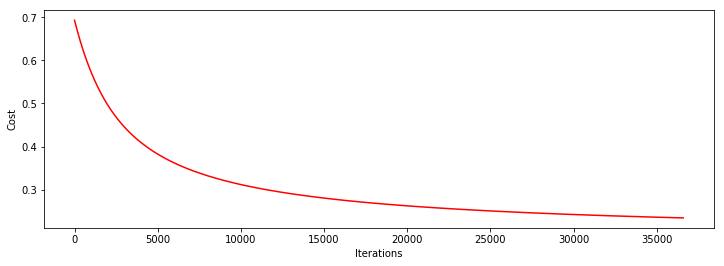

In [36]:
theta5 = Run(scaleData, theta, STOP_COST, 0.000001, 0.001)

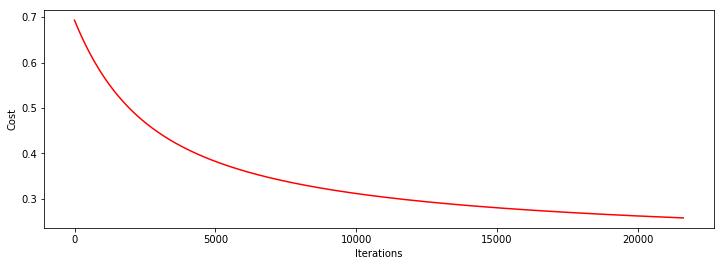

In [37]:
theta6 = Run(scaleData, theta, STOP_GRAD, 0.05, 0.001)

In [38]:
#用训练好的参数来预测结果
def predict(X, theta):
    return [1 if y > 0.5 else 0 for y in model(X, theta)]

In [39]:
#计算准确率
scaleX = scaleData[:, :3]
y = scaleData[:, 3]
predictions = predict(scaleX, theta6)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
accuracy = sum(map(int, correct)) / len(correct)
print('accuracy = {0}%'.format(accuracy * 100))

accuracy = 90.0%
